In [ ]:
import os
from google.colab import drive
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Price History JKH/")
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Price History JKH'

In [ ]:
import pandas as pd

df = pd.read_csv("JKH Historical Data.csv")

df

,Date,Price,Open,High,Low,Vol.,Change %
0,2009-07-08,84.44,85.07,85.39,84.44,198.19K,-0.74%
1,2009-07-09,82.68,84.76,84.76,82.21,183.76K,-2.08%
2,2009-07-13,82.84,82.84,83.48,81.89,164.45K,0.19%
3,2009-07-14,82.53,82.53,82.84,82.21,56.18K,-0.37%
4,2009-07-15,82.68,82.68,82.68,82.21,106.55K,0.18%
...,...,...,...,...,...,...,...
3469,2024-02-21,192.75,191.50,192.75,191.50,372.97K,0.65%
3470,2024-02-22,194.00,192.00,194.50,192.00,679.78K,0.65%
3471,2024-02-26,190.00,194.00,194.25,190.00,179.51K,-2.06%
3472,2024-02-27,189.25,190.00,190.75,189.25,105.71K,-0.39%


In [ ]:
df = df[['Date', 'Price']]

df

,Date,Price
0,2009-07-08,84.44
1,2009-07-09,82.68
2,2009-07-13,82.84
3,2009-07-14,82.53
4,2009-07-15,82.68
...,...,...
3469,2024-02-21,192.75
3470,2024-02-22,194.00
3471,2024-02-26,190.00
3472,2024-02-27,189.25


In [ ]:
import datetime

def str_to_datetime(s):
  split=s.split('-')
  year,month,day=int(split[0]),int(split[1]),int(split[2])
  return datetime.datetime(year=year,month=month,day=day)

In [ ]:
df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-141-a4c74efbab4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']=df['Date'].apply(str_to_datetime)


0      2009-07-08
1      2009-07-09
2      2009-07-13
3      2009-07-14
4      2009-07-15
          ...    
3469   2024-02-21
3470   2024-02-22
3471   2024-02-26
3472   2024-02-27
3473   2024-02-28
Name: Date, Length: 3474, dtype: datetime64[ns]

In [ ]:
df.index=df.pop('Date')
df

,Price
Date,
2009-07-08,84.44
2009-07-09,82.68
2009-07-13,82.84
2009-07-14,82.53
2009-07-15,82.68
...,...
2024-02-21,192.75
2024-02-22,194.00
2024-02-26,190.00


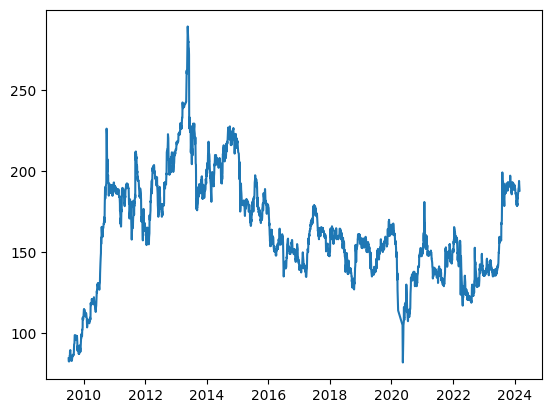

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index,df['Price'])

In [ ]:
import numpy as np
import pandas as pd
import datetime

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Price'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(year=int(year), month=int(month), day=int(day))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n - i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df,
                                '2021-12-31',
                                '2024-02-28',
                                n=3)
windowed_df

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((113,), (113, 3, 1), (113,))

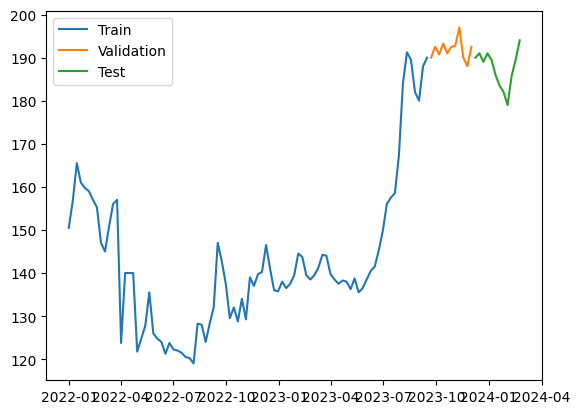

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 325ms/step - loss: 20740.4492 - mean_absolute_error: 143.0182 - val_loss: 36849.3867 - val_mean_absolute_error: 191.9491
Epoch 2/100
3/3 [==============================] - 0s 30ms/step - loss: 20652.9980 - mean_absolute_error: 142.7116 - val_loss: 36739.6797 - val_mean_absolute_error: 191.6631
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 20571.7695 - mean_absolute_error: 142.4257 - val_loss: 36651.2109 - val_mean_absolute_error: 191.4322
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 20504.5469 - mean_absolute_error: 142.1904 - val_loss: 36564.8008 - val_mean_absolute_error: 191.2064
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 20437.2051 - mean_absolute_error: 141.9523 - val_loss: 36471.1133 - val_mean_absolute_error: 190.9612
Epoch 6/100
3/3 [==============================] - 0s 31ms/step - loss: 20365.2148 - mean_absolute_error: 141.6971 - val_loss: 36

3/3 [==============================] - 1s 4ms/step


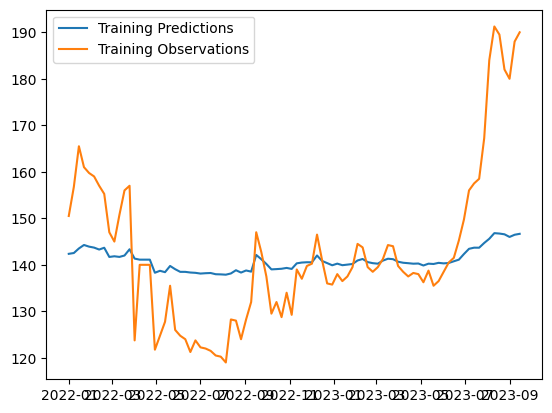

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


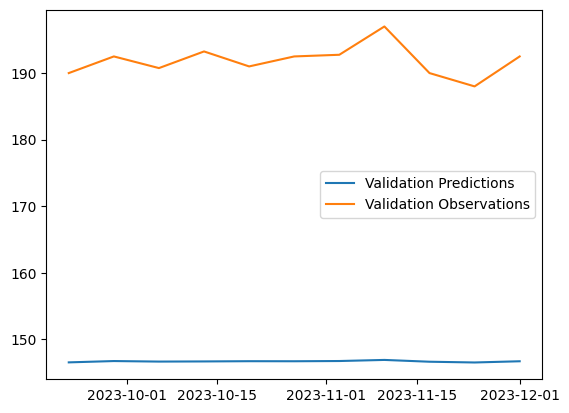

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 35ms/step


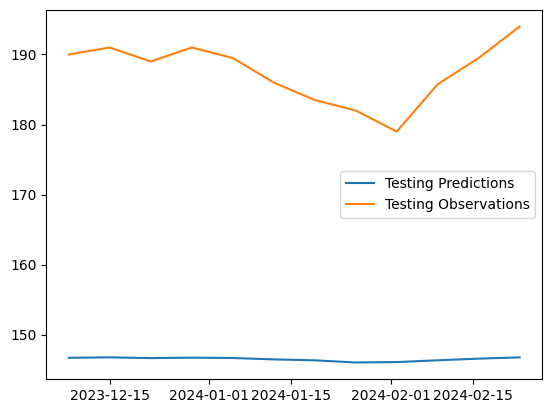

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

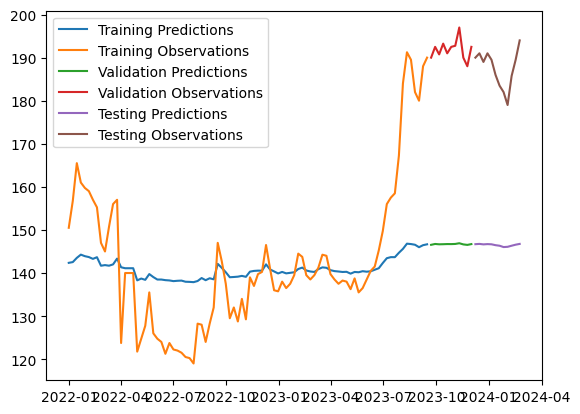

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 21ms/step


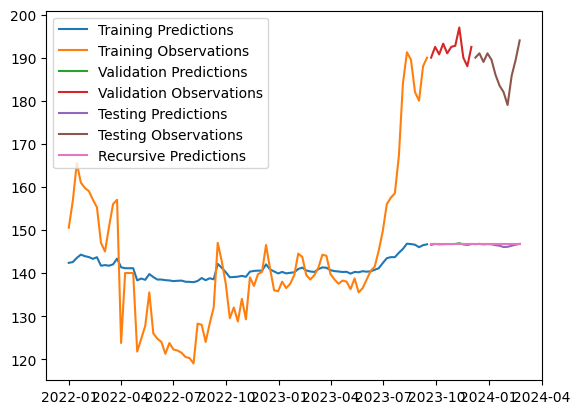

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])